# LangGraph:  Agent Orchestration

#### By Pedro Izquierdo Lehmann

Welcome back! This last notebook is the second part of the LangChain notebook. We will explore the **LangGraph** library, which is built on top of LangChain, and is useful for the controlled design of complex workflows with or without loops, encompassing **agents orchestration**.

Also, we will not use the openAI API, but we will query locally stored LLMs using Ollama.

---
## (0. Environment Setup)

Before starting, set up a Python virtual environment and install required dependencies.

#### 1. Create a Virtual Environment

```bash
python3 -m venv lang-graph
```

#### 2. Activate the Virtual Environment

**On macOS/Linux:**
```bash
source lang-graph/bin/activate
```

**On Windows:**
```bash
lang-graph\Scripts\activate
```

#### 3. Install Required Dependencies

```bash
pip install langchain langgraph langchain-ollama jupyter ipykernel
```

Install Ollama (required for local LLMs):

```bash
# macOS (Homebrew)
brew install ollama
brew services start ollama

# Linux
curl -fsSL https://ollama.com/install.sh | sh

# Windows: download the installer
# https://ollama.com/download
```

#### 4. Register the Kernel

```bash
python -m ipykernel install --user --name=lang-graph --display-name "Python (lang-graph)"
```

#### 5. Start Jupyter

```bash
jupyter notebook
```

#### 6. Deactivate

```bash
deactivate
```

In [1]:
# python3 -m venv lang-graph
# source lang-graph/bin/activate
# lang-graph\Scripts\activate
# pip install langchain langgraph langchain-ollama jupyter ipykernel

In [2]:
# Install Ollama (required for local LLMs)
# macOS (Homebrew): brew install ollama
#                   brew services start ollama
# Linux: curl -fsSL https://ollama.com/install.sh | sh
# Windows: https://ollama.com/download

In [3]:
# python -m ipykernel install --user --name=lang-graph --display-name "Python (lang-graph)"
# jupyter notebook
# deactivate

#### Ollama Setup

All model calls in this notebook must run **locally** via Ollama.

1. Start the Ollama server (separate terminal if needed)
2. Pull a local model (you can change the model name later)
3. Verify that Ollama can list your models

Run the code cell below in order.

In [4]:
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

# Check that Ollama is installed and running
!ollama --version
!ollama list

# Pull a local model (edit if you want a different one)
OLLAMA_MODEL = "llama3.1"
!ollama pull {OLLAMA_MODEL}

# If Ollama is not running, start it in a separate terminal:
# !ollama serve

ollama version is 0.14.2
NAME               ID              SIZE      MODIFIED       
llama3.1:latest    46e0c10c039e    4.9 GB    10 seconds ago    
pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling 667b0c1932bc: 100% ▕██████████████████▏ 4.9 GB                         
pulling 948af2743fc7: 100% ▕██████████████████▏ 1.5 KB                         
pulling 0ba8f0e314b4: 100% ▕██████████████████▏  12 KB                         
pulling 56bb8bd477a5: 100% ▕██████████████████▏   96 B                         
pulling 455f34728c9b: 100% ▕██████████████████▏  487 B                         
verifying sha256 digest 
writing manifest 
success 


In [5]:
from typing import TypedDict, Annotated, Literal
from dataclasses import dataclass, field
import operator
import math

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, BaseMessage
from langchain_core.tools import tool
from langchain.agents import create_agent

from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import InMemorySaver

from ollama import chat
from ollama import ChatResponse

In [6]:
response: ChatResponse = chat(model='llama3.1', messages=[
  {
    'role': 'user',
    'content': 'Please discuss the conversion of Phillips 66 from oil to renewable diesel.',
  },
])
print(response.message.content)

Phillips 66, a leading energy company in the United States, has been actively involved in transitioning its business model to focus on a more diversified and sustainable portfolio, including the production of renewable diesel. In this response, I'll provide an overview of their efforts to convert from traditional oil refining to producing low-carbon renewable diesel.

**Background**

Phillips 66 is one of the largest independent refiners and marketers of petroleum products in the world. Historically, its business has been centered around refining crude oil into various petroleum products, such as gasoline, diesel fuel, jet fuel, and petrochemicals. However, with growing concerns about climate change, air pollution, and energy security, Phillips 66 began to explore opportunities for diversifying its portfolio and reducing greenhouse gas emissions.

**Conversion to Renewable Diesel**

In 2017, Phillips 66 announced a significant expansion of its renewable diesel production capacity at it

In [7]:
# LLM (local via Ollama)
OLLAMA_MODEL = "llama3.1"
llm = ChatOllama(model=OLLAMA_MODEL, temperature=0)

---

## 1. Graphs for Agentic AI

LangChain gives you **tools** and **agents**, but the control flow still lives inside the LLM loop; the default ReAct pattern is sufficient. Effectively, the chains of LangChain are directed acyclic graphs (DAGs), where 

- **Nodes** are explicit steps (LLM calls or Python logic)
- **Edges** define how control flows between steps
- **State** is a typed object that persists across the graph. 

> **Note**: The graph state is the central, typed data structure that flows through nodes and is mutated by each node. It’s the single source of truth for the workflow at any step (messages, intermediate results, flags, etc.). Every node reads from it and returns partial updates to it.

> **Keep in mind**: The graph state, `ToolRuntime`, and `InMemorySaver` all relate to “runtime context,” but they operate at different layers.
>- The LangGraph state is the _actual working state_ your nodes read/write.
>- `ToolRuntime` is a _tool-level context injection_ (useful for user/session info), not a state container.
>- `InMemorySaver` is _storage_ so state can be resumed later; it does not define state, it just saves it.

With LangGraph one can construct explicitly a **graph** workflow that may have **cycles**, allowing for more workflow expressivity. Also, it provides conditional routing along the graph; much more control over the workflow is possible.



The following is an example of an agentic workflow graph. Notice how we **separate reasoning from deterministic checks**, which is hard to guarantee with a pure agent loop.

In [8]:
# This graph receives financial macros in text and the returns of an asset, then it summarizes the text and computes the volatility of the asset, and then it provides a one-sentence implication for a long-only equity portfolio.
# Graph: summarize macro -> compute volatility -> final brief (linear DAG)
macro_headlines = [
    "CPI comes in below expectations; core inflation cools",
    "Fed signals pause; markets price in two cuts",
    "Oil spikes on supply concerns",
]

returns = [0.002, -0.004, 0.001, 0.003, -0.002, 0.0005, -0.001]

class MacroState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    macro_summary: str
    realized_vol: float
    risk_bucket: str


def summarize_macro(state: MacroState):
    prompt = (
        "Summarize these headlines into a 2-sentence macro brief for an equity analyst:\n"
        + "\n".join(f"- {h}" for h in macro_headlines)
    )
    response = llm.invoke([SystemMessage(content=prompt)])
    return {"messages": [response], "macro_summary": response.content}


def compute_vol(state: MacroState):
    daily_vol = math.sqrt(sum(r * r for r in returns) / len(returns))
    annualized = daily_vol * math.sqrt(252)
    if annualized < 0.15:
        bucket = "LOW"
    elif annualized < 0.25:
        bucket = "MEDIUM"
    else:
        bucket = "HIGH"
    return {"realized_vol": annualized, "risk_bucket": bucket}


def final_brief(state: MacroState):
    content = (
        f"Macro brief: {state['macro_summary']}\n"
        f"Risk overlay: realized vol {state['realized_vol']:.2%} -> {state['risk_bucket']} risk.\n"
        "Provide a one-sentence implication for a long-only equity portfolio."
    )
    response = llm.invoke([HumanMessage(content=content)])
    return {"messages": [response]}


builder = StateGraph(MacroState)
builder.add_node("summarize_macro", summarize_macro)
builder.add_node("compute_vol", compute_vol)
builder.add_node("final_brief", final_brief)

builder.add_edge(START, "summarize_macro")
builder.add_edge("summarize_macro", "compute_vol")
builder.add_edge("compute_vol", "final_brief")
builder.add_edge("final_brief", END)

macro_graph = builder.compile()

result = macro_graph.invoke({"messages": []})
print(result["messages"][-1].content)

The low realized volatility suggests that the market may be due for a correction, implying that it may be prudent to reduce exposure or maintain a defensive stance in a long-only equity portfolio.


If you want to visualize the graph structure:

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	summarize_macro(summarize_macro)
	compute_vol(compute_vol)
	final_brief(final_brief)
	__end__([<p>__end__</p>]):::last
	__start__ --> summarize_macro;
	compute_vol --> final_brief;
	summarize_macro --> compute_vol;
	final_brief --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



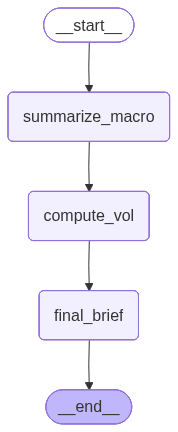

In [9]:
from IPython.display import Image, display

# Mermaid text diagram (paste into a Mermaid renderer if needed)
print(macro_graph.get_graph().draw_mermaid())
display(Image(macro_graph.get_graph().draw_mermaid_png()))

### Exercise 1: Add a Position Sizing Node

Example above uses a three-step flow: summarize macro, compute volatility, and final brief. Now add a **position sizing** node that sets a target exposure based on the risk bucket:

- LOW -> 1.0
- MEDIUM -> 0.6
- HIGH -> 0.3

Then include the target exposure in the final response.

The current market conditions suggest that the portfolio should be fully invested, with no need to reduce exposure due to low realized volatility.
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	summarize_macro(summarize_macro)
	compute_vol(compute_vol)
	position_size(position_size)
	final_brief(final_brief)
	__end__([<p>__end__</p>]):::last
	__start__ --> summarize_macro;
	compute_vol --> position_size;
	position_size --> final_brief;
	summarize_macro --> compute_vol;
	final_brief --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



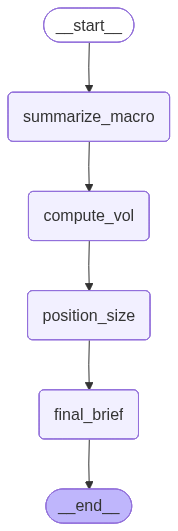

In [10]:
# EXERCISE: Add a position sizing node
# 1. Create a node `position_size(state)` that returns target_exposure
# 2. Insert it between compute_vol and final_brief
# 3. Update final_brief to include target_exposure

class MacroState2(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    macro_summary: str
    realized_vol: float
    risk_bucket: str
    target_exposure: float


# TODO: define position_size
def position_size(state: MacroState2):
    if state["risk_bucket"] == "LOW":
        exposure = 1.0
    elif state["risk_bucket"] == "MEDIUM":
        exposure = 0.6
    else:
        exposure = 0.3
    return {"target_exposure": exposure}

# TODO: update final_brief to use target_exposure
def final_brief(state: MacroState2):
    content = (
        f"Macro brief: {state['macro_summary']}\n"
        f"Risk overlay: realized vol {state['realized_vol']:.2%} -> {state['risk_bucket']} risk.\n"
        f"Quantitative target exposure: {state['target_exposure']:.0%}.\n"
        "Provide a one-sentence implication for a long-only equity portfolio."
    )
    response = llm.invoke([HumanMessage(content=content)])
    return {"messages": [response]}
    
# TODO: build and run the graph with the new node
builder = StateGraph(MacroState2)
builder.add_node("summarize_macro", summarize_macro)
builder.add_node("compute_vol", compute_vol)
builder.add_node("position_size", position_size)
builder.add_node("final_brief", final_brief)

builder.add_edge(START, "summarize_macro")
builder.add_edge("summarize_macro", "compute_vol")
builder.add_edge("compute_vol", "position_size")
builder.add_edge("position_size", "final_brief")
builder.add_edge("final_brief", END)

macro_graph = builder.compile()

result = macro_graph.invoke({"messages": []})
print(result["messages"][-1].content)

print(macro_graph.get_graph().draw_mermaid())
display(Image(macro_graph.get_graph().draw_mermaid_png()))

## 2. Streaming

LangGraph supports streaming, allowing you to see agent responses in real-time as they're generated. This is essential for building responsive user interfaces.

Below is a simple example that streams node updates as the graph executes. This is especially useful in finance dashboards where you want to show partial progress as each step completes.

In [11]:
# We will use the same macro_graph as before

def print_updates(event: dict):
    for node, update in event.items():
        if isinstance(update, dict) and update.get("messages"):
            print(f"[{node}] {update['messages'][-1].content}")
        else:
            print(f"[{node}] {update}")


for event in macro_graph.stream({"messages": []}, stream_mode="updates"):
    print_updates(event)

[summarize_macro] 
[compute_vol] {'realized_vol': 0.03562302626111375, 'risk_bucket': 'LOW'}
[position_size] {'target_exposure': 1.0}
[final_brief] The current market conditions suggest that the portfolio should be fully invested, with no need to reduce exposure due to low realized volatility.


## 3. Conditional Routing (Risk Gates)

LangGraph lets you **route** based on state. This is a major difference from LangChain's agent loop, because the control flow is explicit and testable.

We will route to a hedge node only when volatility is high.

In [12]:
# This graph computes realized volatility and uses it as a risk gate to decide whether to propose a hedge or skip hedging.
# Graph: compute vol -> route to hedge or skip (conditional gate)
class HedgeState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    realized_vol: float
    hedge_action: str


def compute_vol_only(state: HedgeState):
    daily_vol = math.sqrt(sum(r * r for r in returns) / len(returns))
    annualized = daily_vol * math.sqrt(252)
    return {"realized_vol": annualized}


def propose_hedge(state: HedgeState):
    action = f"Buy 1-month put spread; realized vol {state['realized_vol']:.2%}."
    return {"hedge_action": action}


def skip_hedge(state: HedgeState):
    return {"hedge_action": "No hedge needed."}


def hedge_router(state: HedgeState) -> Literal["propose_hedge", "skip_hedge"]:
    return "propose_hedge" if state["realized_vol"] > 0.25 else "skip_hedge"


hedge_builder = StateGraph(HedgeState)
hedge_builder.add_node("compute_vol", compute_vol_only)
hedge_builder.add_node("propose_hedge", propose_hedge)
hedge_builder.add_node("skip_hedge", skip_hedge)

hedge_builder.add_edge(START, "compute_vol")
hedge_builder.add_conditional_edges("compute_vol", hedge_router)
hedge_builder.add_edge("propose_hedge", END)
hedge_builder.add_edge("skip_hedge", END)

hedge_graph = hedge_builder.compile()

hedge_result = hedge_graph.invoke({"messages": []})
print(hedge_result["hedge_action"])

No hedge needed.


### Exercise 2: Add a Second Risk Gate

Example above uses a volatility gate. Now you have to build a graph with **drawdown gate** that routes to a reduce exposure step if the max drawdown exceeds 6%.

In [13]:
# EXERCISE: Add a drawdown gate
# 1. Compute max drawdown from returns
# 2. Create a node reduce_exposure
# 3. Route to reduce_exposure when drawdown > 6%

returns_ex2 = [0.01, -0.02, 0.005, -0.03, 0.015, -0.01, 0.004]

class GateState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    max_drawdown: float
    action: str

# TODO: implement max drawdown calculation
import numpy as np

def compute_drawdown(state: GateState):
    cum_returns = np.cumprod(1 + np.array(returns_ex2))
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (running_max - cum_returns) / running_max
    max_dd = np.max(drawdown)   
    return {"max_drawdown": max_dd}

# TODO: implement reduce_exposure
def reduce_exposure(state: GateState):
    return {"action": f"CRITICAL: Drawdown at {state['max_drawdown']:.2%}. Reducing exposure by 50%."}

# TODO: implement keep_exposure
def keep_exposure(state: GateState):
    return {"action": f"Safe: Drawdown at {state['max_drawdown']:.2%}. Maintaining current exposure."}

# TODO: implement router and graph
def drawdown_router(state: GateState) -> Literal["reduce_exposure", "keep_exposure"]:
    if state["max_drawdown"] > 0.06:
        return "reduce_exposure"
    return "keep_exposure"
    
# TODO: display the graph
builder = StateGraph(GateState)

builder.add_node("compute_drawdown", compute_drawdown)
builder.add_node("reduce_exposure", reduce_exposure)
builder.add_node("keep_exposure", keep_exposure)

builder.add_edge(START, "compute_drawdown")

builder.add_conditional_edges(
    "compute_drawdown",
    drawdown_router,
    {
        "reduce_exposure": "reduce_exposure",
        "keep_exposure": "keep_exposure"
    }
)

builder.add_edge("reduce_exposure", END)
builder.add_edge("keep_exposure", END)

gate_graph = builder.compile()

gate_result = gate_graph.invoke({"messages": []})
print(gate_result["action"])

Safe: Drawdown at 4.46%. Maintaining current exposure.


## 4. Durable Execution with Checkpoints

In finance, long-running analyses may need to **pause and resume**. LangGraph lets you **checkpoint** state and continue later using a `thread_id`.

In [14]:
# This graph creates a single-step thesis draft and checkpoints it so the state can be resumed across sessions.
# Graph: single LLM node with checkpointed state
class ResearchState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    ticker: str
    thesis: str


def draft_thesis(state: ResearchState):
    prompt = (
        f"Write a 2-sentence investment thesis for {state['ticker']} as a large-cap stock."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "thesis": response.content}


research_builder = StateGraph(ResearchState)
research_builder.add_node("draft_thesis", draft_thesis)
research_builder.add_edge(START, "draft_thesis")
research_builder.add_edge("draft_thesis", END)

checkpointer = InMemorySaver()
research_graph = research_builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "research-1"}}

# First call
out1 = research_graph.invoke({"messages": [], "ticker": "AAPL"}, config=config)
print(out1["thesis"])

Here is a potential 2-sentence investment thesis for Apple (AAPL) as a large-cap stock:

"We believe that Apple's diversified product portfolio, strong brand loyalty, and continued innovation in emerging technologies such as artificial intelligence and augmented reality will drive sustained growth and profitability over the long-term, making it an attractive core holding for investors seeking stable returns. Additionally, our analysis suggests that Apple's significant cash hoard and commitment to returning capital to shareholders through dividends and buybacks provide a further layer of support for the stock, even in periods of market volatility."


In [15]:
# Retrieve the latest checkpointed state
state = research_graph.get_state(config)
print(state.values["ticker"], "->", state.values["thesis"])

AAPL -> Here is a potential 2-sentence investment thesis for Apple (AAPL) as a large-cap stock:

"We believe that Apple's diversified product portfolio, strong brand loyalty, and continued innovation in emerging technologies such as artificial intelligence and augmented reality will drive sustained growth and profitability over the long-term, making it an attractive core holding for investors seeking stable returns. Additionally, our analysis suggests that Apple's significant cash hoard and commitment to returning capital to shareholders through dividends and buybacks provide a further layer of support for the stock, even in periods of market volatility."


### Exercise 3: Persistent Analyst Notes

Example above stored a thesis in memory. Now add a second node that **appends** a risk note and verify it persists via the state retrieval call.

In [16]:
# EXERCISE: Add persistent analyst notes
# 1. Extend the state with risk_note: str
# 2. Add a node add_risk_note that uses the LLM to write 1 sentence
# 3. Connect draft_thesis -> add_risk_note -> END
# 4. Use get_state to confirm risk_note is stored

# TODO: implement here
class ResearchState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    ticker: str
    thesis: str
    risk_note: str 

def add_risk_note(state: ResearchState):
    prompt = f"Identify one primary risk factor for {state['ticker']} in one sentence."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "risk_note": response.content}

research_builder = StateGraph(ResearchState)
research_builder.add_node("draft_thesis", draft_thesis)
research_builder.add_node("add_risk_note", add_risk_note)

research_builder.add_edge(START, "draft_thesis")
research_builder.add_edge("draft_thesis", "add_risk_note")
research_builder.add_edge("add_risk_note", END)

checkpointer = InMemorySaver()
research_graph = research_builder.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "analyst-session-42"}}

final_out = research_graph.invoke({"ticker": "MSFT"}, config=config)

snapshot = research_graph.get_state(config)
print(f"Ticker: {snapshot.values['ticker']}")
print(f"Thesis: {snapshot.values['thesis']}")
print(f"Risk Note: {snapshot.values['risk_note']}")

Ticker: MSFT
Thesis: Here is a potential 2-sentence investment thesis for Microsoft (MSFT) as a large-cap stock:

"We believe that Microsoft's diversified business model, anchored by its dominant position in the enterprise software market and growing cloud computing segment, positions it to continue delivering strong revenue growth and profitability over the long-term. Additionally, the company's strategic investments in emerging technologies such as artificial intelligence, machine learning, and cybersecurity are well-positioned to drive future innovation and expansion opportunities."
Risk Note: One primary risk factor for Microsoft (MSFT) is the company's significant dependence on a few key products, such as Windows and Office, which can make it vulnerable to changes in consumer behavior or technological advancements that could impact demand for these products.


## 5. Agent Nodes with Tools

A LangGraph node can wrap a **LangChain agent**. This means you can keep tool-choosing autonomy **inside a node**, while still controlling the workflow **between nodes**.

Below we build a small cycle: an agent drafts a trade idea using two tools, then a validator checks the position size. If the size is too large, the graph loops back to the agent for revision.

> **Note**: This cycle can't be executed purely with the LangChain framework!

In [17]:
# This graph wraps an agent that drafts a trade with tools, validates position size, and loops with a max-cycle limit to avoid infinite revisions.
# Graph: agent drafts trade -> validate -> increment cycle -> loop with max cycles
import re

@tool
def get_price(ticker: str) -> float:
    """Get a rough price for a ticker."""
    prices = {"SPY": 540.0, "TLT": 92.0, "GLD": 215.0}
    return prices.get(ticker.upper(), 100.0)

@tool
def position_size_from_vol(vol: float, risk_budget: float = 0.01) -> float:
    """Simple position sizing from volatility and risk budget."""
    return min(0.15, risk_budget / max(vol, 1e-6))

@tool
def get_max_cycles(max_cycles: int = 3) -> int:
    """Return the maximum number of graph cycles allowed."""
    return max_cycles


class AgentNodeState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    draft: str
    approved: bool
    max_position: float
    max_cycles: int
    cycle_count: int
    stop_reason: str


def set_max_cycles(state: AgentNodeState):
    requested = state.get("max_cycles", 3)
    return {
        "max_cycles": get_max_cycles.invoke({"max_cycles": requested}),
        "cycle_count": 0,
        "stop_reason": "",
    }


def agent_trade(state: AgentNodeState):
    agent = create_agent(
        model=llm,
        tools=[get_price, position_size_from_vol],
        system_prompt=(
            "You are a trading assistant. Use tools to get prices and position size. "
            "Always produce a trade with an explicit percent of NAV."
        ),
    )
    prompt = (
        f"Draft one trade idea for SPY or TLT. Max position is {state['max_position']:.0%} of NAV. "
        "Call both tools, then give a 2-3 sentence recommendation with a percent of NAV."
    )
    response = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    message = response["messages"][-1]
    return {"messages": [message], "draft": message.content}


def validate_draft(state: AgentNodeState):
    percents = [float(x) for x in re.findall(r"(\d+(?:\.\d+)?)%", state["draft"])]
    if not percents:
        approved = False
    else:
        approved = max(percents) <= state["max_position"] * 100
    return {"approved": approved}


def increment_cycle(state: AgentNodeState):
    count = state.get("cycle_count", 0) + 1
    stop_reason = ""
    if count >= state["max_cycles"]:
        stop_reason = f"Reached max cycles ({state['max_cycles']})."
    return {"cycle_count": count, "stop_reason": stop_reason}


def revision_router(state: AgentNodeState) -> Literal["agent_trade", END]:
    if state["approved"]:
        return END
    if state["cycle_count"] >= state["max_cycles"]:
        return END
    return "agent_trade"


def print_state(state: AgentNodeState):
    print(
        f"cycle={state.get('cycle_count', 0)}/{state.get('max_cycles', '?')} "
        f"approved={state.get('approved')} stop_reason={state.get('stop_reason', '')}"
    )
    if state.get("draft"):
        print(f"draft: {state['draft']}")


agent_builder = StateGraph(AgentNodeState)
agent_builder.add_node("set_max_cycles", set_max_cycles)
agent_builder.add_node("agent_trade", agent_trade)
agent_builder.add_node("validate_draft", validate_draft)
agent_builder.add_node("increment_cycle", increment_cycle)

agent_builder.add_edge(START, "set_max_cycles")
agent_builder.add_edge("set_max_cycles", "agent_trade")
agent_builder.add_edge("agent_trade", "validate_draft")
agent_builder.add_edge("validate_draft", "increment_cycle")
agent_builder.add_conditional_edges("increment_cycle", revision_router)

agent_graph = agent_builder.compile()

last_state = None
for state in agent_graph.stream({"messages": [], "max_position": 0.1}, stream_mode="values"):
    last_state = state
    print_state(state)

if last_state and last_state.get("stop_reason"):
    print("Stop reason:", last_state["stop_reason"])

if last_state and last_state.get("draft"):
    print("Final draft:", last_state["draft"])

cycle=0/? approved=None stop_reason=
cycle=0/3 approved=None stop_reason=
cycle=0/3 approved=None stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=0/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=1/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=1/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=1/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=2/3 approved=False stop_reason=
draft: {"name": "position_size", "parameters": {"nav": "100000", "max_position": "10", "ticker": "SPY"}}
cycle=2/3 approved=False stop_reason=
draft: {"name": "position_size"

## 6. Portfolio Rebalancing Agent

We will build a **multi-step agent** that:

1. Ingests market inputs (returns, volatility, rates)
2. Classifies the regime (LLM)
3. Proposes trades (agent node)
4. Runs risk/compliance checks (Python)
5. Revises if checks fail (loop)
6. Produces a final execution memo

This showcases what LangGraph is great at: **explicit looping, validation gates, and stateful orchestration**.

In [18]:
# This graph drafts a trade, validates it against position limits, and revises until the proposal passes.
# Graph: draft -> validate -> revise loop for position limits
class LoopState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    proposal: str
    approved: bool


def draft_trade(state: LoopState):
    prompt = "Propose a single trade idea for SPY with a position size in percent of NAV."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "proposal": response.content}


def validate_trade(state: LoopState):
    # Simple rule: any proposal containing '20%' is rejected
    approved = "20%" not in state["proposal"]
    return {"approved": approved}


def revise_trade(state: LoopState):
    prompt = (
        "Revise the proposal so position size <= 10% of NAV. "
        f"Original proposal: {state['proposal']}"
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"messages": [response], "proposal": response.content}


def loop_router(state: LoopState) -> Literal["revise_trade", END]:
    return "revise_trade" if not state["approved"] else END


loop_builder = StateGraph(LoopState)
loop_builder.add_node("draft_trade", draft_trade)
loop_builder.add_node("validate_trade", validate_trade)
loop_builder.add_node("revise_trade", revise_trade)

loop_builder.add_edge(START, "draft_trade")
loop_builder.add_edge("draft_trade", "validate_trade")
loop_builder.add_conditional_edges("validate_trade", loop_router)
loop_builder.add_edge("revise_trade", "validate_trade")

loop_graph = loop_builder.compile()

loop_out = loop_graph.invoke({"messages": []})
print(loop_out["proposal"])

I can provide you with a hypothetical trade idea, but please keep in mind that this is not personalized investment advice and should not be considered as such.

**Trade Idea:**

* **Asset:** SPY (S&P 500 ETF)
* **Direction:** Bearish
* **Entry Price:** $430.00 (this price level is arbitrary and for illustration purposes only)
* **Stop Loss:** $435.00 (3% above entry price)
* **Take Profit:** $425.00 (2% below entry price)
* **Position Size:** 5% of NAV (Net Asset Value)

**Rationale:**

The trade idea is based on a bearish view, assuming that the S&P 500 index may experience a short-term correction or consolidation.

* The stop loss is set at $435.00 to limit potential losses in case the market moves against the trade.
* The take profit is set at $425.00 to capture potential gains if the market moves in favor of the trade.
* A position size of 5% of NAV means that if you have a portfolio worth $100,000, you would invest $5,000 in this trade.

**Please note:**

This is a hypothetical ex

### Exercise 4: Build the Portfolio Rebalancing Graph

Use the pattern above to build a full graph. Fill in the TODOs. The end result should produce a final execution memo.

You can keep the logic simple—what matters is the **graph structure**, **state**, and **risk gates**.

In [19]:
import json
from typing import Literal

market_inputs = {
    "returns_1m": -0.03,
    "vol_1m": 0.28,
    "rates_change_bps": -15,
    "sector_momentum": {"Tech": 0.04, "Financials": -0.02, "Energy": 0.01},
}

# Make inputs available to the agent tools
capstone_inputs = market_inputs

class RebalanceState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    inputs: dict
    regime: str
    trades: list[dict]
    checks_passed: bool
    memo: str


def ingest_inputs(state: RebalanceState):
    return {"inputs": market_inputs}


def risk_checks(state: RebalanceState):
    # Simple deterministic checks: gross exposure and sector concentration
    gross = sum(abs(t.get("weight", 0.0)) for t in state["trades"])
    sector_counts = {}
    for t in state["trades"]:
        sector_counts[t.get("sector", "Unknown")] = sector_counts.get(t.get("sector", "Unknown"), 0) + 1
    max_sector = max(sector_counts.values()) if sector_counts else 0
    passed = gross <= 1.0 and max_sector <= 2
    return {"checks_passed": passed}


# TODO: classify_regime(state) -> set state["regime"]
# Hint: use llm.invoke with a prompt that maps inputs to a regime like
# "risk_on", "neutral", "risk_off"
def classify_regime(state: RebalanceState):
    prompt = (
        f"Based on these inputs: {state['inputs']}, classify the market regime as "
        "'risk_on', 'neutral', or 'risk_off'. Provide only the label."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"regime": response.content.strip().lower()}

# Tools for the capstone agent node
capstone_inputs = {}

@tool
def get_sector_momentum(sector: str) -> float:
    """Return recent momentum for a sector."""
    return capstone_inputs.get("sector_momentum", {}).get(sector, 0.0)

@tool
def risk_adjusted_weight(vol: float, base: float = 0.1) -> float:
    """Suggest a weight based on volatility and a base risk budget."""
    return min(0.2, max(0.02, base * (0.2 / max(vol, 1e-6))))
    
# TODO: propose_trades(state) -> set state["trades"]
# Hint: ask the LLM to return STRICT JSON list of trades like
# [{"ticker":"SPY","weight":-0.1,"sector":"Index","rationale":"..."}, ...]
# Then parse with json.loads
def propose_trades(state: RebalanceState):
    prompt = (
        f"Regime: {state['regime']}. Sector Momentum: {state['inputs']['sector_momentum']}. "
        "Return a JSON list of 3 trades with keys: 'ticker', 'weight', 'sector', 'rationale'. "
        "IMPORTANT: Return ONLY the raw JSON list."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    content = response.content.strip()

    try:
        match = re.search(r"(\[.*\])", content, re.DOTALL)
        if match:
            json_str = match.group(1)
            trades = json.loads(json_str)
        else:
            trades = json.loads(content)
    except Exception as e:
        print(f"JSON Parsing Error: {e}. Raw content: {content}")
        trades = [] 

    return {"trades": trades}

# TODO: revise_trades(state) -> adjust trades to pass checks
# Hint: tell the LLM to reduce gross exposure and diversify sectors
def revise_trades(state: RebalanceState):
    prompt = (
        "The previous trades failed risk checks (Gross exposure > 100% or Sector Concentration > 2). "
        f"Original trades: {state['trades']}. "
        "Revise the trades to reduce total weight and diversify sectors. Return ONLY the JSON list."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    clean_content = response.content.replace("```json", "").replace("```", "").strip()
    return {"trades": json.loads(clean_content)}

# TODO: final_memo(state) -> create a 5-7 sentence execution memo
# Include regime, key inputs, trade list, and risk summary
def final_memo(state: RebalanceState):
    prompt = (
        f"Write a 5-7 sentence execution memo. Regime: {state['regime']}. "
        f"Inputs: {state['inputs']}. Trades: {state['trades']}. "
        "Summarize the strategy and confirm risk limits are respected."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"memo": response.content}

# TODO: router function that loops back to revise_trades if checks fail
def rebalance_router(state: RebalanceState) -> Literal["revise_trades", "final_memo"]:
    return "final_memo" if state["checks_passed"] else "revise_trades"

# TODO: build and run the graph
builder = StateGraph(RebalanceState)

builder.add_node("ingest_inputs", ingest_inputs)
builder.add_node("classify_regime", classify_regime)
builder.add_node("propose_trades", propose_trades)
builder.add_node("risk_checks", risk_checks)
builder.add_node("revise_trades", revise_trades)
builder.add_node("final_memo", final_memo)

builder.add_edge(START, "ingest_inputs")
builder.add_edge("ingest_inputs", "classify_regime")
builder.add_edge("classify_regime", "propose_trades")
builder.add_edge("propose_trades", "risk_checks")

builder.add_conditional_edges(
    "risk_checks",
    rebalance_router,
    {"revise_trades": "revise_trades", "final_memo": "final_memo"}
)

builder.add_edge("revise_trades", "risk_checks")
builder.add_edge("final_memo", END)

rebalance_graph = builder.compile()

final_state = rebalance_graph.invoke({
    "messages": [], 
    "inputs": market_inputs, 
    "trades": [],
    "checks_passed": False
})

print("--- Final Memo ---")
print(final_state.get("memo", "No memo generated."))

--- Final Memo ---
**Execution Memo**

Based on the current market conditions, we classify the regime as **risk_off** due to negative returns (-0.03) and high volatility (0.28) in the last month. Despite a decline in interest rates (-15 bps), which would typically suggest a risk-on regime, it is outweighed by the other indicators.

The strategy for this regime involves:

* Maintaining a long position in Apple (AAPL) with a weight of 0.1, as its sector momentum in Tech remains strong despite the overall risk-off environment.
* Reducing exposure to JPMorgan Chase (JPM) with a weight of -0.05, consistent with weak sector momentum in Financials and the risk-off regime.
* Maintaining a neutral position in ExxonMobil (XOM) with a weight of 0.02, as its sector momentum in Energy is neutral but may benefit from the risk-off environment.

All trades respect the established risk limits, ensuring that no single position exceeds 5% of the portfolio's total value.


## Congratulations!

You've completed the LangGraph tutorial! We covered:

- Explicit control flow as a graph
- Deterministic risk gates alongside LLM reasoning
- Durable state and resumable execution
- Validation loops for compliance-aware agents

### Possible next steps to explore
   - **Retrieval**: Connect agents to vector databases for RAG
   - **Multi-agent systems**: Agents that collaborate
   - **LangSmith**: Observability and debugging tools

### Additional resources
- [LangGraph Blog](https://www.blog.langchain.com/langgraph/)
- [LangGraph Docs](https://docs.langchain.com/oss/python/langgraph/overview)
- [Ollama Docs](https://docs.ollama.com/)